In [52]:
import pandas as pd
import numpy as np
import scanpy as sc
import pickle
import scipy
import itertools

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.pyplot import rc_context
import seaborn as sns
from ete3 import Tree
from copy import copy
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [2]:
# Multiseq (AM-DNA-258) scanpy object
multiSeq = sc.read_h5ad('/Genomics/chanlab/blaw/TLS/raw_data/scRNA/TLSCL/TLS_TLSCL.h5ad')
multiSeq_BC = pd.read_csv('/Genomics/chanlab/blaw/TLS/metadata/multiseq_barcodes.txt', sep = '\t')

In [3]:
clusterColorsFile = "/Genomics/chanlab/mchan/Adriano/TLS/TLS_TLSCL/20211102_clusterColorsTLSCL.p"
with open(clusterColorsFile,'rb') as fp:
    colorDict = pickle.load(fp)

### Label the multiseq dataframe by the TLS barcode

In [4]:
def addTLSCL(BC):
    test = multiSeq_BC.set_index('Sequence').loc[BC]['TLS ID']
    if test.startswith('TLSCL'):
        return 'TLSCL'
    elif test == 'Doublet':
        return 'Doublet'
    elif test == 'Negative':
        return 'Negative'
    else:
        return 'TLS'

In [5]:
def addBC(BC):
    return multiSeq_BC.set_index('Sequence').loc[BC]['ID']

In [6]:
df2 = pd.DataFrame({"ID":['Doublet', 'Negative'],
                    "TLS ID":['Doublet', 'Negative'], 
                    "Sequence":['Doublet', 'Negative']})

In [7]:
multiSeq_BC = pd.concat([multiSeq_BC, df2])

In [8]:
multiSeq.obs['Condition'] = multiSeq.obs['MultiSeqBCseq'].map(addTLSCL)
multiSeq.obs['multiSeqBC'] = multiSeq.obs['MultiSeqBCseq'].map(addBC)

# Create a table of the compositions for all structures

In [13]:
structure_composition = pd.DataFrame(columns = colorDict.keys(), 
                                     index = np.unique(multiSeq.obs['multiSeqBC']))

In [14]:
for cell_state in colorDict.keys():
    for index in np.unique(multiSeq.obs['multiSeqBC']):
        structure_composition.loc[index][cell_state] = len(multiSeq.obs[(multiSeq.obs['multiSeqBC'] == index) & (multiSeq.obs['cell_state'] == cell_state)]['cell_state'])

In [19]:
structure_composition.to_csv('/Genomics/chanlab/blaw/TLS/data/AM-DNA-258/composition/structure_compositions.txt', sep = '\t')

In [35]:
composition = pd.read_csv('/Genomics/chanlab/blaw/TLS/data/AM-DNA-258/composition/structure_compositions.txt', index_col = 0, sep = '\t')
composition.drop(index = ['Bar8', 'Bar18', 'Doublet', 'Negative'], inplace = True)

# PCA of structure compositions

In [36]:
df = composition.T.copy()

# Normalize the barcodes to sum to 1
df_norm = df.div(df.sum(axis=0), axis=1)

# mean center the cell types
df_mean_center = df_norm.sub(df_norm.mean(axis = 1), axis = 0)

In [37]:
pca = PCA()
pca.fit(df_mean_center)

PCA()

In [38]:
print('PC1 variance: {}'.format(pca.explained_variance_ratio_[0] * 100))

PC1 variance: 69.44321278341461


In [39]:
print('PC1 variance: {}'.format(pca.explained_variance_ratio_[1] * 100))

PC1 variance: 19.92586851424953


In [41]:
TLS_barcodes = ['Bar1', 'Bar2', 'Bar4', 'Bar5', 'Bar7', 'Bar10', 'Bar11', 'Bar13', 'Bar16', 'Bar19', 'Bar22']
TLSCL_barcodes = ['Bar3', 'Bar6', 'Bar9', 'Bar12', 'Bar14', 'Bar15', 'Bar20', 'Bar21', 'Bar23', 'Bar24']
labels = df_mean_center.columns

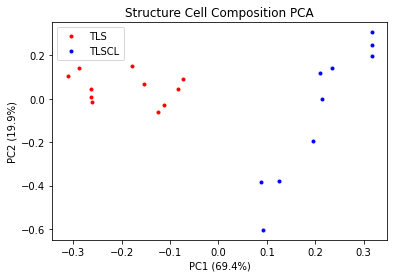

In [42]:
TLS_components1 = []
TLS_components2 = []

TLSCL_components1 = []
TLSCL_components2 = []

for i, label in enumerate(labels):
    if label in TLS_barcodes:
        TLS_components1.append(pca.components_[0][i])
        TLS_components2.append(pca.components_[1][i])
    else:
        TLSCL_components1.append(pca.components_[0][i])
        TLSCL_components2.append(pca.components_[1][i])

plt.plot(TLS_components1, TLS_components2, '.r', label = 'TLS')
plt.plot(TLSCL_components1, TLSCL_components2, '.b', label = 'TLSCL')
    
plt.legend()
plt.xlabel('PC1 (69.4%)')
plt.ylabel('PC2 (19.9%)')
plt.title('Structure Cell Composition PCA')
plt.savefig('/Genomics/chanlab/blaw/TLS/data/AM-DNA-258/composition/TLS_TLSCL_Full_Composition_PCA.pdf', dpi = 300)
plt.show()
plt.close()


### Heatmap of structure cell state compositions

In [43]:
# calculate zscore based off mean and std of each cell type
df_zscore = composition.copy()

for cell_state in composition.columns:
    mean = composition[cell_state].mean()
    std = composition[cell_state].std()
    
    for barcode in df_zscore.index:
        df_zscore.loc[barcode, cell_state] = (composition.loc[barcode][cell_state] - mean) / std

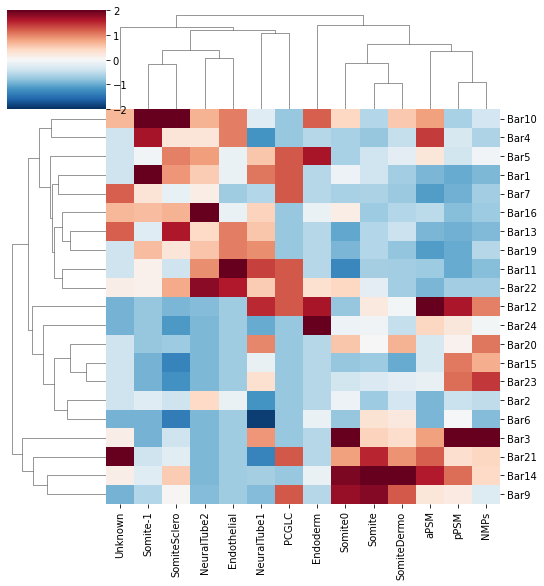

In [44]:
temp = df_zscore.copy()
#temp.drop(index = ['Unknown'], inplace = True)
g = sns.clustermap(temp, cmap = 'RdBu_r', vmin = -2, vmax = 2)
plt.subplots_adjust(bottom = 0.3, right = 0.7)
plt.savefig('/Genomics/chanlab/blaw/TLS/data/AM-DNA-258/composition/Structure_Composition_Zscores.pdf', dpi = 300)

# Boxplot of neural, somite, and NMP

In [45]:
TLS_n_counts = []
TLS_s_counts = []
TLS_NMP_counts = []

TLSCL_n_counts = []
TLSCL_s_counts = []
TLSCL_NMP_counts = []

composition_norm = df_norm.T.copy()

for barcode in composition.index:
    if barcode in TLS_barcodes:
        TLS_n_counts.append(composition_norm.loc[barcode, 'NeuralTube1'] + composition_norm.loc[barcode, 'NeuralTube2'])
        TLS_s_counts.append(composition_norm.loc[barcode, 'aPSM'] + composition_norm.loc[barcode, 'pPSM'] +
                            composition_norm.loc[barcode, 'Somite-1'] + composition_norm.loc[barcode, 'Somite0'] +
                            composition_norm.loc[barcode, 'Somite'] + composition_norm.loc[barcode, 'SomiteSclero'] + 
                            composition_norm.loc[barcode, 'SomiteDermo'])
        TLS_NMP_counts.append(composition_norm.loc[barcode, 'NMPs'])
    else:
        TLSCL_n_counts.append(composition_norm.loc[barcode, 'NeuralTube1'] + composition_norm.loc[barcode, 'NeuralTube2'])
        TLSCL_s_counts.append(composition_norm.loc[barcode, 'aPSM'] + composition_norm.loc[barcode, 'pPSM'] +
                            composition_norm.loc[barcode, 'Somite-1'] + composition_norm.loc[barcode, 'Somite0'] +
                            composition_norm.loc[barcode, 'Somite'] + composition_norm.loc[barcode, 'SomiteSclero'] + 
                            composition_norm.loc[barcode, 'SomiteDermo'])
        TLSCL_NMP_counts.append(composition_norm.loc[barcode, 'NMPs'])

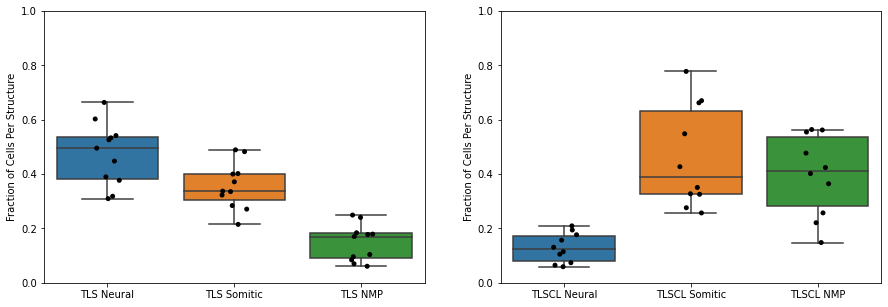

In [46]:
test = pd.DataFrame({'TLS Neural': TLS_n_counts,
                     'TLS Somitic': TLS_s_counts,
                     'TLS NMP': TLS_NMP_counts})

fig, ax = plt.subplots(1, 2, figsize = (15, 5))
    
ax1 = ax[0]
sns.boxplot(ax = ax1, data = test)
sns.stripplot(data = test, ax = ax1, color = 'black')
ax1.set_ylabel('Fraction of Cells Per Structure')
ax1.set_ylim(0, 1)

test_CL = pd.DataFrame({'TLSCL Neural': TLSCL_n_counts,
                     'TLSCL Somitic': TLSCL_s_counts,
                     'TLSCL NMP': TLSCL_NMP_counts})

ax2 = ax[1]
sns.boxplot(ax = ax2, data = test_CL)
sns.stripplot(data = test_CL, ax = ax2, color = 'black')
ax2.set_ylabel('Fraction of Cells Per Structure')
ax2.set_ylim(0, 1)
plt.savefig('/Genomics/chanlab/blaw/TLS/data/AM-DNA-258/composition/TLS_TLSCL_Neural_Somite_NMP.pdf', dpi = 300)
plt.show()
plt.close()

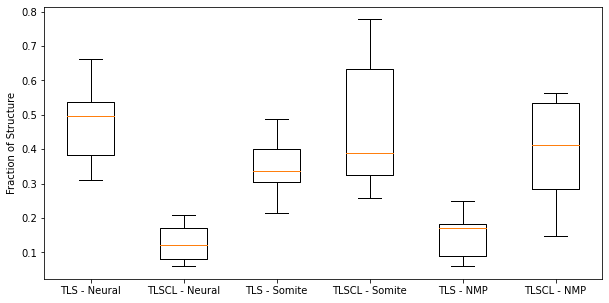

In [47]:
fig = plt.subplots(figsize = (10, 5))
labels = ['TLS - Neural', 'TLSCL - Neural', 'TLS - Somite', 'TLSCL - Somite', 'TLS - NMP', 'TLSCL - NMP']
data = [TLS_n_counts, TLSCL_n_counts, TLS_s_counts, TLSCL_s_counts, TLS_NMP_counts, TLSCL_NMP_counts]

plt.boxplot(data,
           labels = labels)

plt.ylabel('Fraction of Structure')
plt.show()
plt.close()

# Calculate pairwise aitchison distance between TLS structures

Aitchison distance takes the euclidean distance after performing a centered log-ratio (clr) transformation
- clr(X) = [ln (x1/g(X)), …, ln (Xj / g(Xj))]
- g(x) is the geometric mean of all values in X


So the distance between 2 composition vectors Xi, Xj is given by:
- d(X, Y) = sqrt( sum from g=1 to D ( ln (Xg / g(X)) - ln (Yg / g(Y)) )^2)

In [57]:
def aitchensonDist (x, y):
    '''
    Input:
        x - a list or array of composition values in sample1
        y - a list or array of composition values in sample2
        
        Assumes that all 0 values have been removed and that the composition values in the list are connected by index
    return:
        a distance between the 2 vectors
    '''
    meanX = sum(x) / len(x)
    meanY = sum(y) / len(y)
    
    distSum = 0
    
    for index, value in enumerate(x):
        tempX = np.log(x[index] / meanX)
        tempY = np.log(y[index] / meanY)
        
        distSum += (tempX - tempY) ** 2
        
    return np.sqrt(distSum)

In [76]:
# add a 0.01 pseudocount
structure_composition = structure_composition + 0.0001

In [77]:
structure_dists = []

for ref1, ref2 in list(itertools.combinations(TLS_barcodes, 2)):
    x = structure_composition.loc[ref1]
    y = structure_composition.loc[ref2]
    structure_dists.append(aitchensonDist(x, y))

In [78]:
# adding a pseudocount of 0.01 to each cell state so that we don't have to remove any
test_clone_dists = []

# cutoff to remove a clone based off the number of cells 
clone_cutoff = 2

for barcode in TLS_barcodes:
    test_tree_loc = '/Genomics/chanlab/blaw/TLS/data/AM-DNA-258/lineage/3_lineage_reconstruction/{}/{}_newick_noMutationlessEdges_Labeled.nwk'.format(barcode, barcode)
    test_t = Tree(test_tree_loc, format=1)

    # create a dataframe to hold the composition counts within one barcode
    test_composition_df = pd.DataFrame(index = colorDict.keys(), columns = [i.name for i in test_t.children])

    # List of clones to remove from distance comparisions:
    bad_clones = []
    
    # fill the dataframe with the composition counts per clone
    for clone in test_t.children:
        leaves = ['TLS_TLSCL_' + i.name for i in clone.get_leaves()]
        states = multiSeq.obs.loc[leaves]['cell_state'].value_counts().to_dict()
        for state in colorDict.keys():
            if state in states.keys():
                test_composition_df.loc[state][clone.name] = states[state]
            else:
                test_composition_df.loc[state][clone.name] = 0
                
        # remove clones below the cutoff
        if len(leaves) < clone_cutoff:
            bad_clones.append(clone.name)
    
    # add a pseudocount of 0.0001
    test_composition_df = test_composition_df + 0.0001
    
    for node1, node2 in list(itertools.combinations(test_composition_df.drop(columns = bad_clones).columns, 2)):
        x = test_composition_df[node1]
        y = test_composition_df[node2]
        test_clone_dists.append(aitchensonDist(x, y))

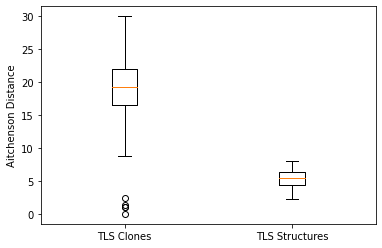

In [79]:
test = {'TLS Clones' : test_clone_dists, 'TLS Structures' : structure_dists}

fig, ax = plt.subplots()
ax.boxplot(test.values())
ax.set_xticklabels(test.keys())
#plt.errorbar(x, height, e, linestyle='None', marker='^')
plt.ylabel('Aitchenson Distance')
#plt.xlabel('TLS Clones')
plt.savefig('/Genomics/chanlab/blaw/TLS/data/AM-DNA-258/composition/TLS_Aitchison_Dist.pdf', dpi = 300)
plt.show()
plt.close()

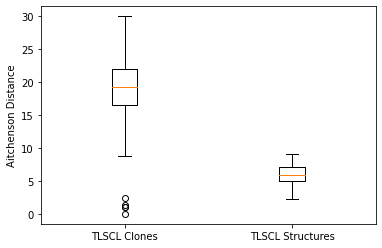

In [70]:
test = {'TLSCL Clones' : test_clone_dists, 'TLSCL Structures' : structure_dists}

fig, ax = plt.subplots()
ax.boxplot(test.values())
ax.set_xticklabels(test.keys())
#plt.errorbar(x, height, e, linestyle='None', marker='^')
plt.ylabel('Aitchenson Distance')
#plt.xlabel('TLS Clones')
plt.savefig('/Genomics/chanlab/blaw/TLS/data/AM-DNA-258/composition/TLSCL_Aitchison_Dist.pdf', dpi = 300)
plt.show()
plt.close()